In [105]:
import os
from pathlib import Path

from typing import Tuple, Dict, List
from timeit import default_timer as timer
import random
from PIL import Image

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

print(torch.__version__)

import warnings
warnings.filterwarnings("ignore")

2.0.1+cu118


Set device

In [3]:
SEED = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Get data

In [4]:
import requests
import zipfile

data_path = Path("data/")
image_path = data_path/ "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory already exists. Skipping download...")
else:
    print(f"Creating {image_path} directory...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download data
with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza_steak_sushi data...")
    f.write(request.content)

# Unzip zip folder
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unziping pizza_steak_sushi data...")
    zip_ref.extractall(image_path)

Creating data/pizza_steak_sushi directory...
Unziping pizza_steak_sushi data...


In [5]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi.
There are 3 directories and 0 images in data/pizza_steak_sushi/train.
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi.
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak.
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza.
There are 3 directories and 0 images in data/pizza_steak_sushi/test.
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi.
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak.
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza.


In [6]:
train_dir = image_path/"train"
test_dir = image_path/"test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Image path: data/pizza_steak_sushi/test/sushi/46797.jpg
Image class: sushi
Image width x height: 512 x 384


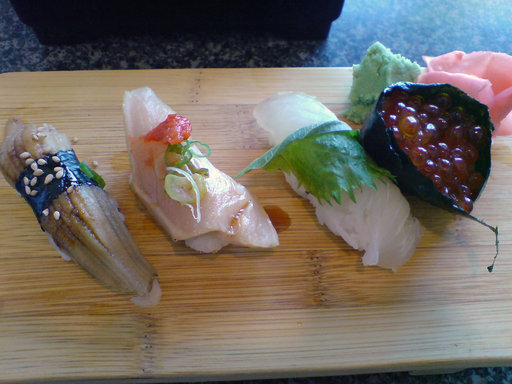

In [7]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Visualize random image
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
print(f"Image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image width x height: {img.width} x {img.height}")
img

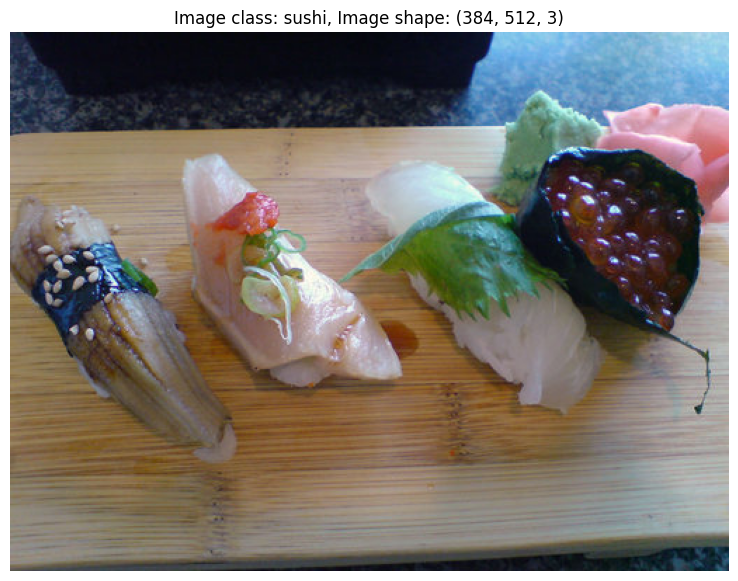

In [8]:
img_as_array = np.asarray(img)
plt.figure(figsize =(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class}, Image shape: {img_as_array.shape}")
plt.axis(False)
plt.show()

### Convert images to tensors
* Resize images to 64x64 for our mini VGG model
* Data augmentation
* Convert image to tensor

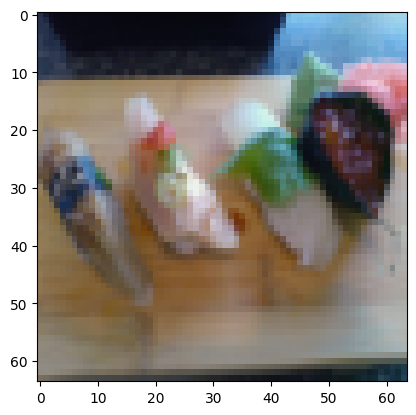

In [9]:
data_transform = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
plt.imshow(data_transform(img).permute(1,2,0))

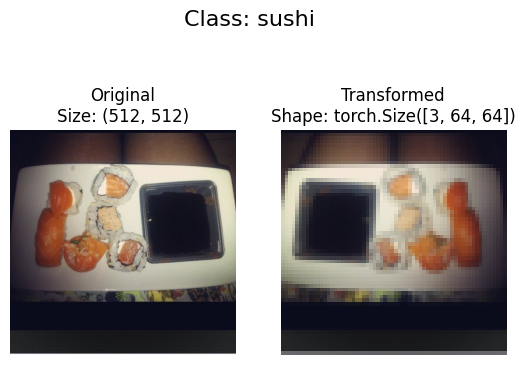

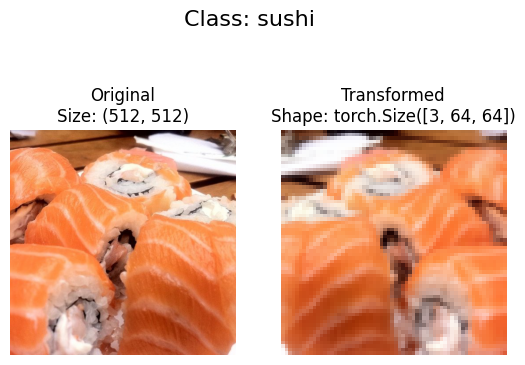

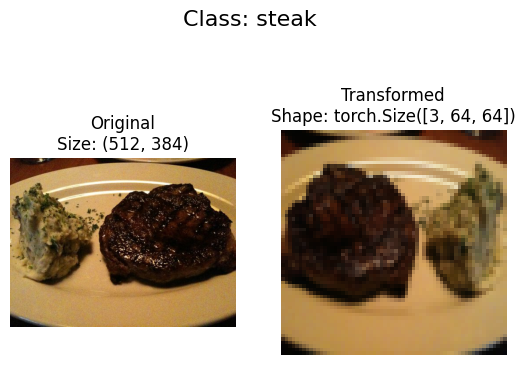

In [10]:
def plot_transformed_images(image_paths, transform, n=3, seed = SEED):
    """Transforms images and plots the transformed images
    with the original
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k = n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows = 1, ncols = 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)
            
            transformed_image = transform(f)
            ax[1].imshow(transformed_image.permute(1,2,0))
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis(False)
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)

plot_transformed_images(image_path_list, data_transform)

### Option 1: Load image using `ImageFolder`

In [11]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform, #transform for the data
                                  target_transform = None #transform for the label
                                  )

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [12]:
# Get class names
class_dict = {v:k for k, v in train_data.class_to_idx.items()}
class_dict

{0: 'pizza', 1: 'steak', 2: 'sushi'}

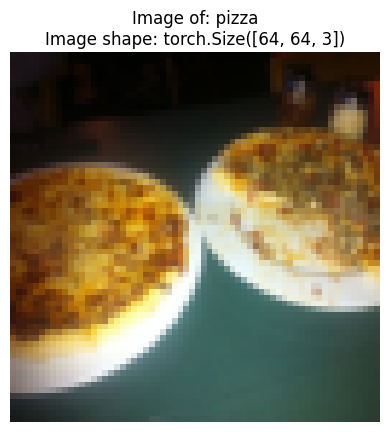

In [13]:
img, label = train_data[0][0], train_data[0][1]
plt.imshow(img.permute(1,2,0))
plt.title(f"Image of: {class_dict[label]}\nImage shape: {img.permute(1,2,0).shape}")
plt.axis(False)
plt.show()

In [14]:
os.cpu_count()

2

In [15]:
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = 1, #or os.cpu_count()
                              shuffle = True)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = 1,
                             shuffle = False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f29181878e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f2918187d90>)

In [16]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> batch_size, color_channels, height, width")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> batch_size, color_channels, height, width
Label shape: torch.Size([1])


### Option 2: Use `Custom Dataset`
The advantage of doing this is that you can add customizability.

In [17]:
target_directory = train_dir
sorted(entry.name for entry in list(os.scandir(target_directory)) if entry.is_dir())

['pizza', 'steak', 'sushi']

In [18]:
list(os.scandir(target_directory))

[<DirEntry 'sushi'>, <DirEntry 'steak'>, <DirEntry 'pizza'>]

In [19]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Use os.scandir() to traverse a target directory and get class names
    Turn class names into a dict and returns it
    """
    classes = sorted(entry.name for entry in list(os.scandir(target_directory)) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Could not find any classes in {directory}...\nPlease check file structure")
    class_to_idx = {class_name:i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [20]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [21]:
class ImageFolderCustom(torch.utils.data.Dataset):
    """Custom dataset object
    """
    def __init__(self, target_directory: str = None, transform = None):
        """Class constructor. Takes in a target directory filepath and
        optionally a torch transform.
        """
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(target_directory)
        self.paths = list(Path(target_directory).glob("*/*.jpg"))
    def load_image(self, index: int) -> Image.Image:
        """Opens an image given a path and returns it
        """
        image_path = self.paths[index]
        return Image.open(image_path)
    def __len__(self):
        """Returns total number of samples
        """
        return len(self.paths)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """Overrides __getitem__ method to return a particular sample
        Returns one sample of data -> X and y. If a transform is specified,
        returns the transformed image and label. Otherwise, just returns
        original image and label.
        """
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [22]:
# Create train and test transforms
train_transforms = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor() 
])

test_transforms = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()
])

In [23]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(target_directory = train_dir,
                                      transform = train_transforms)
test_data_custom = ImageFolderCustom(target_directory = test_dir,
                                     transform = test_transforms)

len(train_data_custom), len(test_data_custom)

(225, 75)

In [24]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### Create function to display random images
Takes in a `dataset` and other parameters such as class names and how many images to visualize. Set random seed for reproducibility.

In [25]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = SEED): 
    """Displays random images
    """
    if n>10:
        n = 10
        display_shape = False
        print(f"For display purposes, n should not be larger than 10. Setting to 10 and removing shaped display..")
    if seed:
        random.seed(seed)
    random_samples_idx = random.sample(range(len(dataset)), k = n)
    
    plt.figure(figsize = (20,10))
    for i, sample in enumerate(random_samples_idx):
        image, label = dataset[sample][0], dataset[sample][1]
        image_plot = image.permute(1,2,0)
        plt.subplot(1, n, i+1)
        plt.imshow(image_plot)
        plt.axis("off")
        if classes:
            title = f"Class: {classes[label]}"
            if display_shape:
                title = title + f"\nshape: {image_plot.shape}"
            plt.title(title)

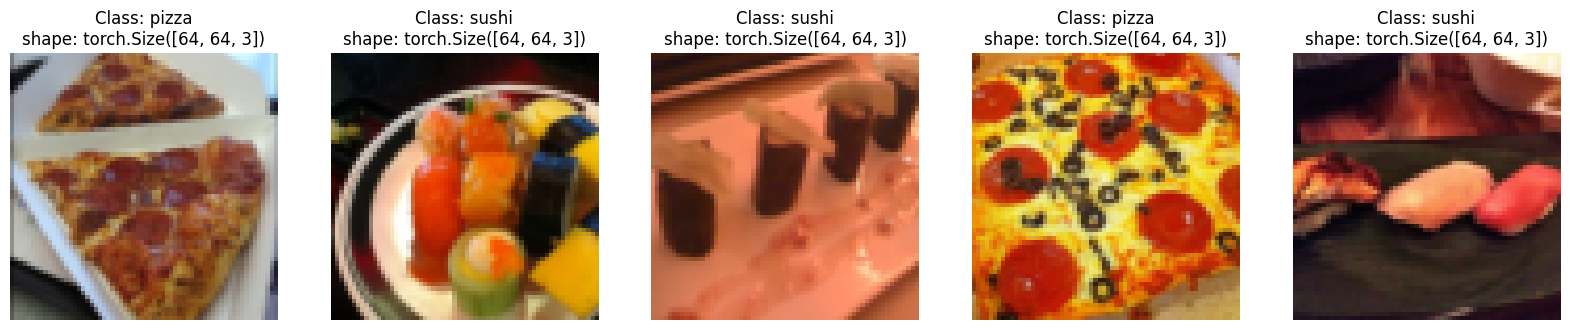

In [26]:
display_random_images(train_data_custom, classes = train_data_custom.classes, n = 5)

Turn custom datasets into dataloaders

In [27]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset = train_data_custom,
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = True)
test_dataloader_custom = DataLoader(dataset = test_data_custom,
                             batch_size = BATCH_SIZE,
                             num_workers = NUM_WORKERS,
                             shuffle = False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f2918095840>,
 <torch.utils.data.dataloader.DataLoader at 0x7f29180958a0>)

In [28]:
#Get image and label from dataloader
img, label = next(iter(train_dataloader_custom))
img.shape, label.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

#### Data augmentation
Let's look at trivial augment - it applies a random data augmentation to the dataset. The PyTorch team has used this transformation to enhance SOTA mdoels. https://arxiv.org/abs/2103.10158
> Artificially adding diversity to training data so that the model doesn't "memorize" the image but learns generalizable features from the image to better predict on unseen data.

In [29]:
custom_train_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=5), #the augmentation's intensity is between 0-5
    transforms.ToTensor()
])
custom_test_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor()
])

In [30]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/sushi/497686.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/773725.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1070104.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/710379.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2021685.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/855721.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/14046.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/169392.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2574453.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2019344.jpg')]

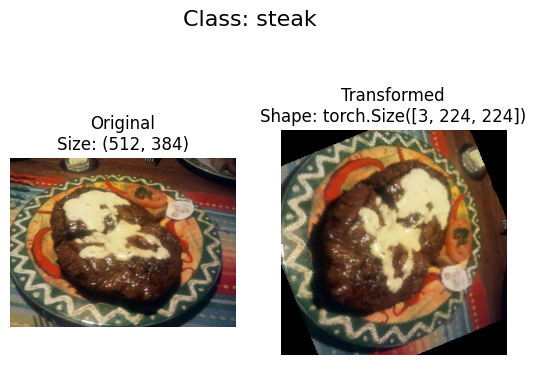

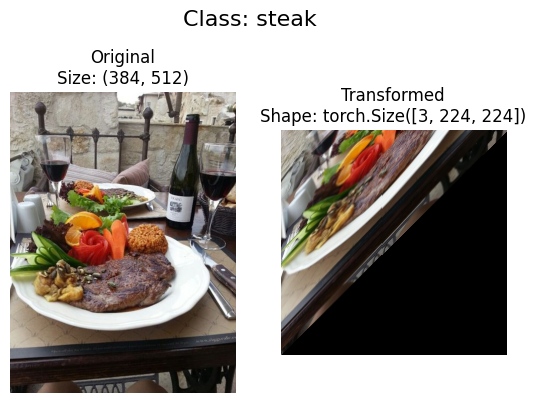

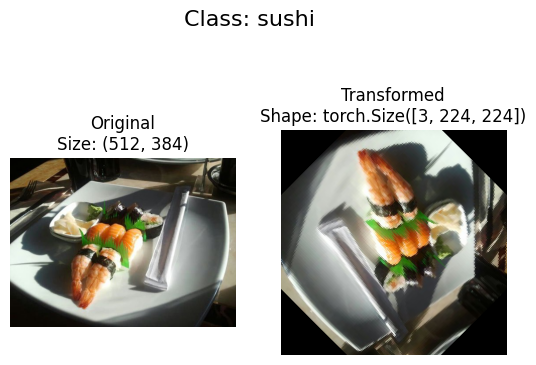

In [31]:
plot_transformed_images(
    image_paths = image_path_list,
    transform = custom_train_transform,
    n = 3,
    seed = None
)

### Building baseline model (model0): TinyVGG without data augmentation

In [32]:
# Create transforms and load data for model 0
simple_transform = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()
])

train_data_simple = datasets.ImageFolder(root = train_dir, 
                                         transform = simple_transform)
test_data_simple = datasets.ImageFolder(root = test_dir, 
                                        transform = simple_transform)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size = BATCH_SIZE,
                                     num_workers = NUM_WORKERS,
                                     shuffle = True)
test_dataloader_simple = DataLoader(test_data_simple,
                                     batch_size = BATCH_SIZE,
                                     num_workers = NUM_WORKERS,
                                     shuffle = False)

In [33]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [34]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape
x = model_0(image_batch.to(device))
x.shape

torch.Size([32, 3])

In [35]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
from torchinfo import summary
summary(model_0, input_size = [1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [37]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [38]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [39]:
torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

NUM_EPOCHS = 5
model0 = TinyVGG(input_shape = 3,
                 hidden_units = 10,
                 output_shape = 3).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model0.parameters(),
                             lr = 0.001)

from timeit import default_timer as timer
start_time = timer()
model0_results = train(model = model0,
                       train_dataloader = train_dataloader_simple,
                       test_dataloader = test_dataloader_simple,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = NUM_EPOCHS)
end_time = timer()
print(f"Time elapsed: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1360 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0847 | train_acc: 0.4258 | test_loss: 1.1620 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1157 | train_acc: 0.2930 | test_loss: 1.1697 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0955 | train_acc: 0.4141 | test_loss: 1.1385 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0985 | train_acc: 0.2930 | test_loss: 1.1428 | test_acc: 0.1979
Time elapsed: 11.040 seconds


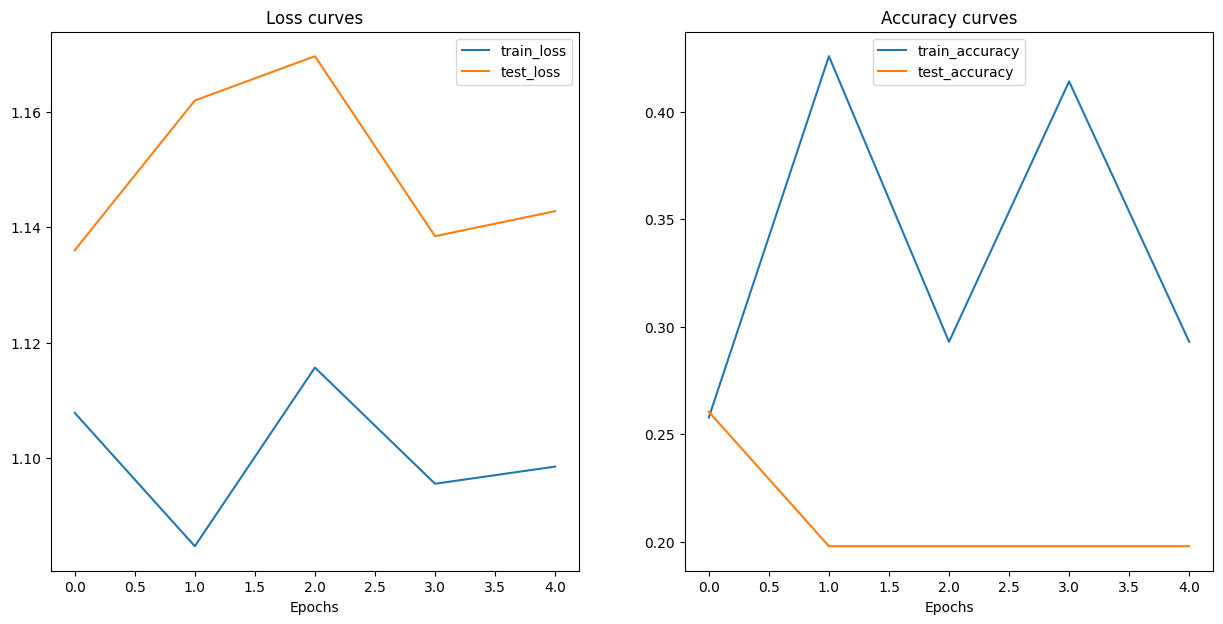

In [40]:
#Plot loss curves of model 0

def plot_loss_curves(results: Dict[str, List[float]]):
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    train_accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]
    epochs = range(len(results["train_loss"]))
    
    plt.figure(figsize = (15,7))
    
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label = "train_loss")
    plt.plot(epochs, test_loss, label = "test_loss")
    plt.title("Loss curves")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(epochs, train_accuracy, label = "train_accuracy")
    plt.plot(epochs, test_accuracy, label = "test_accuracy")
    plt.title("Accuracy curves")
    plt.xlabel("Epochs")
    plt.legend()

plot_loss_curves(model0_results)

## Model 1: TinyVGG with data augmentation
> We're going to use trivial_augment

In [41]:
train_transform_trivial = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [42]:
train_data_augmented = datasets.ImageFolder(root = train_dir, 
                                            transform = train_transform_trivial)
test_data_simple = datasets.ImageFolder(root = test_dir, 
                                        transform = test_transform_simple)
BATCH_SIZE = 32
train_dataloader_augmented = DataLoader(dataset = train_data_augmented,
                                        batch_size = BATCH_SIZE,
                                        num_workers = NUM_WORKERS,
                                        shuffle = True)
test_dataloader_augmented = DataLoader(dataset = test_data_simple,
                                       batch_size = BATCH_SIZE,
                                       num_workers = NUM_WORKERS,
                                       shuffle = False)

train_data_augmented, test_data_simple


(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [43]:
torch.manual_seed(SEED)
model_1 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data_augmented.classes)).to(device)
summary(model_1, input_size = [1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [44]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(),
                             lr = 0.001)

from timeit import default_timer as timer
start_time = timer()
model1_results = train(model = model_1,
                       train_dataloader = train_dataloader_augmented,
                       test_dataloader = test_dataloader_augmented,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = NUM_EPOCHS)
end_time = timer()
print(f"Time elapsed: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1241 | train_acc: 0.3008 | test_loss: 1.1207 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.1069 | train_acc: 0.3008 | test_loss: 1.1200 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.0981 | train_acc: 0.2930 | test_loss: 1.1318 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.1135 | train_acc: 0.2969 | test_loss: 1.1284 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.1014 | train_acc: 0.3047 | test_loss: 1.0969 | test_acc: 0.2604
Time elapsed: 9.076 seconds


Using MPS caused the notebook to crash at this point. There appears to be some compatibility issues between Torch and the M1 chip

In [45]:
!nvidia-smi

Thu Jun  1 13:47:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    29W /  70W |   1187MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Data augmentation helps with overfitting so it made the model worst in this case because the previous model was already underfitting.

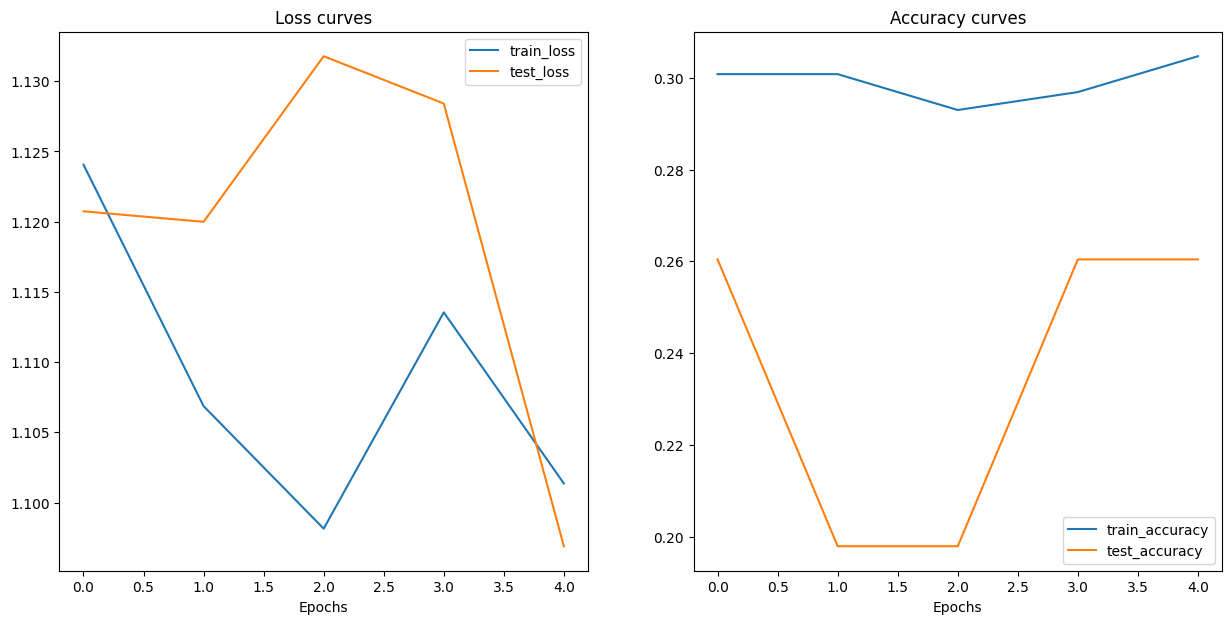

In [46]:
plot_loss_curves(model1_results)

It's quite interesting that the test loss is much higher than the training loss.

### Compare model results of all of our models against each other
We are currently hardcoding functions to compare. But there are other tools such like PyTorch's tensorboard that we can use for comparison 😃
> We're still going to use the hardcoding method for this notebook

In [47]:
import pandas as pd
model_0_df = pd.DataFrame(model0_results)
model_1_df = pd.DataFrame(model1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.107833,0.257812,1.136041,0.260417
1,1.084714,0.425781,1.161997,0.197917
2,1.115691,0.292969,1.169676,0.197917
3,1.095547,0.414062,1.138467,0.197917
4,1.098517,0.292969,1.142809,0.197917


Plotting all of them against each other

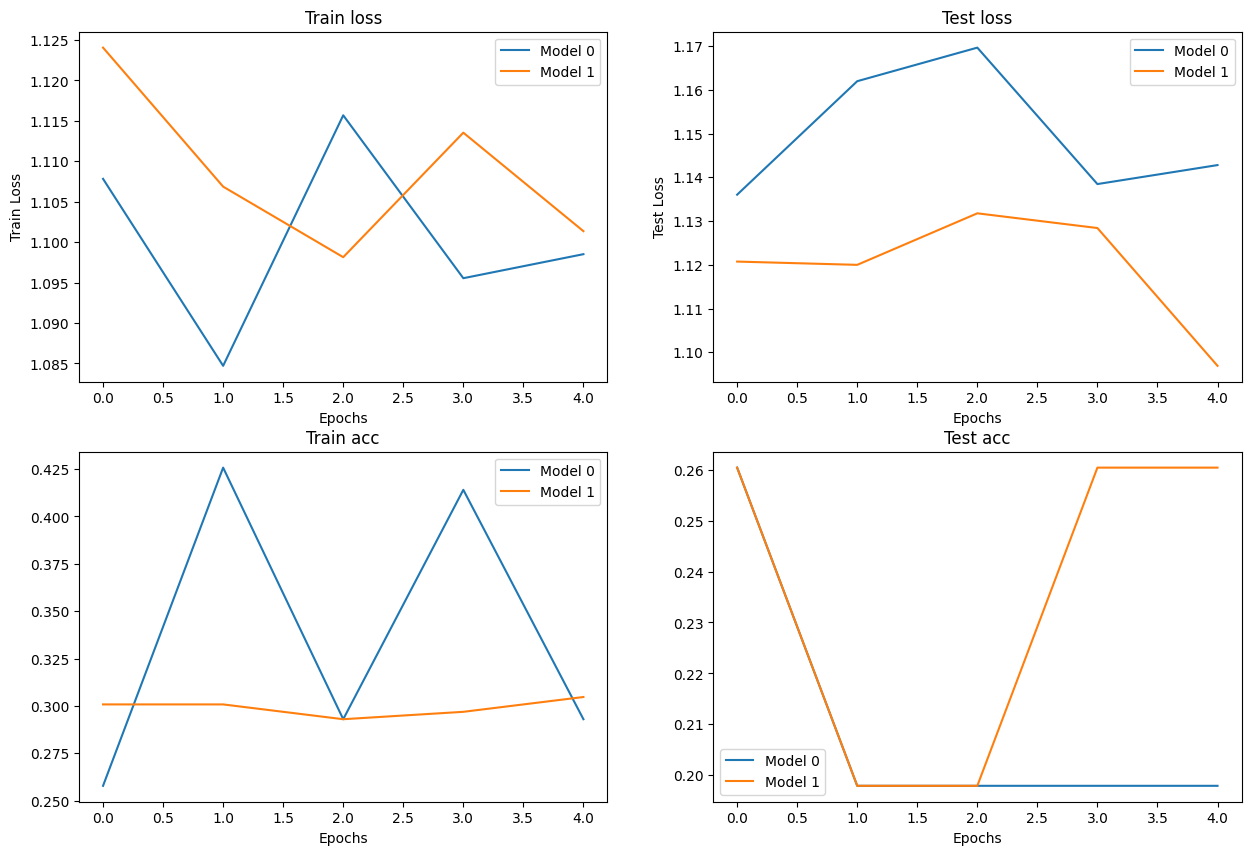

In [51]:
plt.figure(figsize = (15,10))
epochs = range(len(model_0_df))

#plot losses
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label = "Model 0")
plt.plot(epochs, model_1_df["train_loss"], label = "Model 1")
plt.title("Train loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Train Loss")

plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label = "Model 0")
plt.plot(epochs, model_1_df["test_loss"], label = "Model 1")
plt.title("Test loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Test Loss")

#plot accuracy
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"], label = "Model 0")
plt.plot(epochs, model_1_df["train_acc"], label = "Model 1")
plt.title("Train acc")
plt.legend()
plt.xlabel("Epochs")

plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"], label = "Model 0")
plt.plot(epochs, model_1_df["test_acc"], label = "Model 1")
plt.title("Test acc")
plt.legend()
plt.xlabel("Epochs")

plt.show()

### Predicting on an image from the wild
> This image is not in our training or testing data

In [50]:
# Download custom image
import requests

if not os.path.exists("data/"):
    os.makedirs("data")

data_path = Path("data/")

# Setup custom image path
custom_image_path = data_path/"04-pizza-dad.jpeg"

#Download image if it does not already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists. Skipping download..")    

Loading custom image with torch and place it on the right device
> https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html

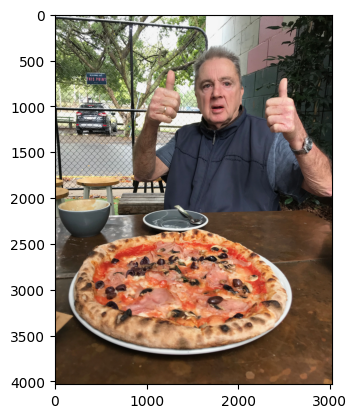

In [61]:
import torchvision
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
plt.imshow(custom_image_uint8.permute(1,2,0))

Per the documentation, torchvision.io reads an image as uint8. We need to convert this to torch.float32 for deep laerning.

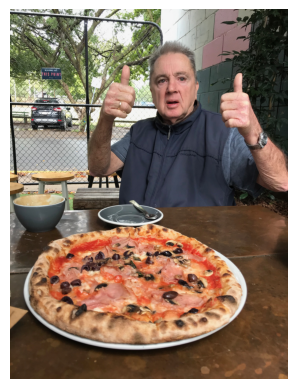

In [72]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
custom_image = custom_image/255.
plt.imshow(custom_image.permute(1,2,0))
plt.axis(False);

In [73]:
transform_simple = transforms.Compose([
    transforms.Resize((64, 64))
])

custom_image_transformed = transform_simple(custom_image)
print(custom_image_transformed.shape)

torch.Size([3, 64, 64])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [86]:
model_1.eval()
with torch.inference_mode():
  # add batch dimension
  custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(0)
  pred = torch.argmax(
      torch.softmax(model_1(custom_image_transformed_with_batch_size.to(device)),
                    dim = 1),
                    dim = 1).cpu()
pred

tensor([0])

### Build a function where we pass an image path to our model and have the model predict on that image

In [107]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform = None,
                        device = device):
  """Makes prediction on target image with a trained model
  and plots the image and the prediction
  """
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
  target_image = target_image/255.
  target_image = target_image.unsqueeze(0)
  if transform:
    target_image = transform(target_image)
  
  model.to(device)
  model.eval()
  with torch.inference_mode():
    prob = torch.softmax(model(target_image.to(device)),dim = 1).cpu()
    pred = torch.argmax(prob, dim = 1).item()
                         
  #Plot image
  plt.imshow(target_image.squeeze(0).permute(1,2,0));
  if class_names:
    title = f"Pred: {class_names[pred]} | Probability: {prob.max():.3f}"
  else:
    title = f"Pred: {pred} | Probability: {prob.max():.3f}"
  plt.title(title)
  plt.axis(False)
    

pizza


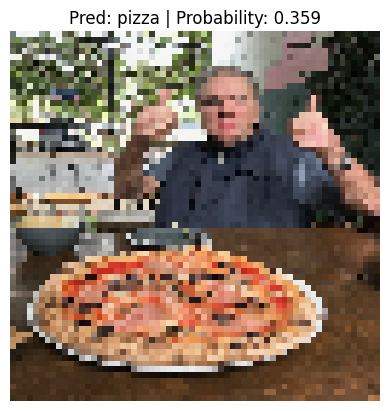

In [106]:
pred_and_plot_image(model = model_1,
                    image_path = custom_image_path,
                    class_names = class_dict,
                    transform = transform_simple,
                    device= device)

## Assignment

There are 3 ways to improve model performance
1. Increase number of epochs
2. Change image dimensions to become larger - (224, 224, 3)
3. Remove data augmentation - let the model overfit first before augmenting
4. Increase the number of hidden units

In [2]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [72]:
import os
from pathlib import Path
from typing import Tuple, Dict, List

from timeit import default_timer as timer
import random
from collections import defaultdict
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchinfo import summary

import zipfile
import requests

print(torch.__version__)

2.0.1+cu118


In [13]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [16]:
SEED = 42
BATCH_NUMBER = 32
NUM_WORKERS = os.cpu_count()
LR = 0.001
EPOCHS = 20

### Get more data

In [4]:
def get_data(dir_name: str,
             subfolder_name: str,
             url: str):
  
  # Create dir
  if not os.path.exists(dir_name):
    os.makedirs(dir_name)
  dir_path = Path(dir_name)
  subfolder_path = dir_path/subfolder_name
  if subfolder_path.is_dir():
    print(f"{subfolder_path} directory already exists. Skipping download...")
  else:
    print(f"Creating {subfolder_path} directory...")
  
  # Download data
  with open(dir_path/f"{subfolder_name}.zip", "wb") as f:
    request = requests.get(url)
    print("Downloading 20 percent pizza, steak, sushi data")
    f.write(request.content)
  
  #Unzip folder
  with zipfile.ZipFile(dir_path/f"{subfolder_name}.zip", "r") as zip_ref:
    print("Unzipping downloaded data...")
    zip_ref.extractall(subfolder_path)
  
  return subfolder_path

In [5]:
image_path = get_data(dir_name = "data_20",
                      subfolder_name = "pizza_steak_sushi",
                      url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")

Creating data_20/pizza_steak_sushi directory...
Unzipping downloaded data...


In [6]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

walk_through_dir(image_path)

There are 2 directories and 0 images in data_20/pizza_steak_sushi.
There are 3 directories and 0 images in data_20/pizza_steak_sushi/train.
There are 0 directories and 150 images in data_20/pizza_steak_sushi/train/sushi.
There are 0 directories and 154 images in data_20/pizza_steak_sushi/train/pizza.
There are 0 directories and 146 images in data_20/pizza_steak_sushi/train/steak.
There are 3 directories and 0 images in data_20/pizza_steak_sushi/test.
There are 0 directories and 46 images in data_20/pizza_steak_sushi/test/sushi.
There are 0 directories and 46 images in data_20/pizza_steak_sushi/test/pizza.
There are 0 directories and 58 images in data_20/pizza_steak_sushi/test/steak.


In [7]:
train_dir = image_path/"train"
test_dir = image_path/"test"
train_dir, test_dir

(PosixPath('data_20/pizza_steak_sushi/train'),
 PosixPath('data_20/pizza_steak_sushi/test'))

## Build dataloaders

Increase resolution of resized image for transforms. Left data augmentation inside first because the assignment did not say to take it out

In [17]:
train_transform = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(root = train_dir,
                                  transform = train_transform)
test_data = datasets.ImageFolder(root = test_dir,
                                 transform = test_transform)

In [18]:
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = NUM_WORKERS,
                             shuffle = False)

# Check dimensions
img_batch, label = next(iter(train_dataloader))
print(f"Image shape: {img_batch.shape} -> batch_size, color_channels, height, width")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> batch_size, color_channels, height, width
Label shape: torch.Size([32])


In [19]:
class_names = {v:k for k, v in train_data.class_to_idx.items()}
class_names

{0: 'pizza', 1: 'steak', 2: 'sushi'}

In [20]:
class TinyVGG2(nn.Module):
  def __init__(self, num_color_channels: int, hidden_units: int, num_classes: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = num_color_channels,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size = 3, padding =1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units * 56 * 56,
                  out_features = num_classes)
    )
  def forward(self, x: torch.Tensor):
      return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [21]:
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

model = TinyVGG2(num_color_channels = 3,
                 hidden_units = 20,
                 num_classes = 3).to(device)

In [22]:
summary(model, [32, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG2                                 [32, 3]                   --
├─Sequential: 1-1                        [32, 20, 112, 112]        --
│    └─Conv2d: 2-1                       [32, 20, 224, 224]        560
│    └─ReLU: 2-2                         [32, 20, 224, 224]        --
│    └─Conv2d: 2-3                       [32, 20, 224, 224]        3,620
│    └─ReLU: 2-4                         [32, 20, 224, 224]        --
│    └─MaxPool2d: 2-5                    [32, 20, 112, 112]        --
├─Sequential: 1-2                        [32, 20, 56, 56]          --
│    └─Conv2d: 2-6                       [32, 20, 112, 112]        3,620
│    └─ReLU: 2-7                         [32, 20, 112, 112]        --
│    └─Conv2d: 2-8                       [32, 20, 112, 112]        3,620
│    └─ReLU: 2-9                         [32, 20, 112, 112]        --
│    └─MaxPool2d: 2-10                   [32, 20, 56, 56]          --
├─Seq

In [23]:
optimizer = torch.optim.Adam(model.parameters(),
                             lr = LR)
loss_fn = nn.CrossEntropyLoss()

In [31]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: str = device) -> Tuple[float, float]:
    """Helper function to train pytorch model on device
    and acquire training metrics per epoch

    Args:
        model (torch.nn.Module): instantiated torch model
        dataloader (torch.utils.data.DataLoader)
        loss_fn (torch.nn.Module)
        optimizer (torch.optim.Optimizer) 
        device (str, optional): Defaults to device.

    Returns:
        Average training loss and training accuracy per epoch
    """
    
    train_loss, train_acc = 0,0
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        
        # Forward pass
        X, y = X.to(device), y.to(device)
        y_pred = model(X) #logits
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute metric across all batches
        y_pred_class = torch.argmax(
            torch.softmax(y_pred, dim = 1),
            dim = 1
        )

        train_acc += (y_pred_class==y).sum().item()/len(y_pred)
    
    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc/len(dataloader)

    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: str = device) -> Tuple[float, float]:
    """Runs inference of trained model on test dataset per epoch
    and monitors model test metrics.

    Args:
        model (torch.nn.Module): instantiated torch model
        dataloader (torch.utils.data.DataLoader)
        loss_fn (torch.nn.Module)
        device (str, optional): _description_. Defaults to device.

    Returns:
        Average test loss and test accuracy per epoch
    """
    
    test_loss, test_acc = 0,0
    model.eval()
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            
            # Forward pass
            X, y = X.to(device), y.to(device)
            test_pred = model(X) #logits

            # Compute metrics 
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            test_pred_class = torch.argmax(
                torch.softmax(test_pred, dim = 1),
                dim = 1
            )
            test_acc += (test_pred_class == y).sum().item()/len(test_pred_class)
    
    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss/len(dataloader)
    test_acc = test_acc/len(dataloader)
    
    return test_loss, test_acc


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = EPOCHS) -> Dict(List):
    """Wrapper function to train model over specified number of epochs,
    model, dataloaders, optimizer and loss function.

    Args:
        model (torch.nn.Module): instantiated torch model
        train_dataloader (torch.utils.data.DataLoader)
        test_dataloader (torch.utils.data.DataLoader)
        optimizer (torch.optim.Optimizer)
        loss_fn (torch.nn.Module, optional) Defaults to nn.CrossEntropyLoss().
        epochs (int, optional): Defaults to EPOCHS.

    Returns:
        Dictionary of results
    """
    
    # Create storage results dictionary
    results = defaultdict(list)

    # Loop through training and testing steps for number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model,
                                           dataloader = train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer = optimizer)
        test_loss, test_acc = test_step(model = model,
                                        dataloader = test_dataloader,
                                        loss_fn = loss_fn)
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    return results

In [33]:
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

from timeit import default_timer as timer
start_time = timer()
model_results = train(model = model,
                      train_dataloader = train_dataloader,
                      test_dataloader = test_dataloader,
                      optimizer = optimizer)
end_time = timer()
print(f"Time elapsed: {end_time - start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6138 | train_acc: 0.7458 | test_loss: 1.0269 | test_acc: 0.5636
Epoch: 2 | train_loss: 0.4335 | train_acc: 0.8354 | test_loss: 1.2089 | test_acc: 0.5506
Epoch: 3 | train_loss: 0.5399 | train_acc: 0.7625 | test_loss: 1.0176 | test_acc: 0.5977
Epoch: 4 | train_loss: 0.4350 | train_acc: 0.8438 | test_loss: 1.0328 | test_acc: 0.5733
Epoch: 5 | train_loss: 0.4615 | train_acc: 0.8125 | test_loss: 1.0979 | test_acc: 0.5642
Epoch: 6 | train_loss: 0.4918 | train_acc: 0.8000 | test_loss: 0.9711 | test_acc: 0.6381
Epoch: 7 | train_loss: 0.4901 | train_acc: 0.8125 | test_loss: 1.0188 | test_acc: 0.6165
Epoch: 8 | train_loss: 0.4817 | train_acc: 0.8063 | test_loss: 0.9819 | test_acc: 0.6011
Epoch: 9 | train_loss: 0.3673 | train_acc: 0.8604 | test_loss: 1.0863 | test_acc: 0.6227
Epoch: 10 | train_loss: 0.4181 | train_acc: 0.8167 | test_loss: 1.0406 | test_acc: 0.5949
Epoch: 11 | train_loss: 0.4188 | train_acc: 0.8354 | test_loss: 1.0688 | test_acc: 0.5972
Epoch: 12 | train_l

In [37]:
model_df = pd.DataFrame(model_results)
model_df.head()

,train_loss,train_acc,test_loss,test_acc
0,0.613815,0.745833,1.026942,0.563636
1,0.433467,0.835417,1.208883,0.550568
2,0.539945,0.762500,1.017622,0.597727
3,0.435045,0.843750,1.032821,0.573295
4,0.461462,0.812500,1.097883,0.564205


In [41]:
EPOCHS == len(model_df)

True

In [45]:
epochs = range(EPOCHS)
epochs

range(0, 20)

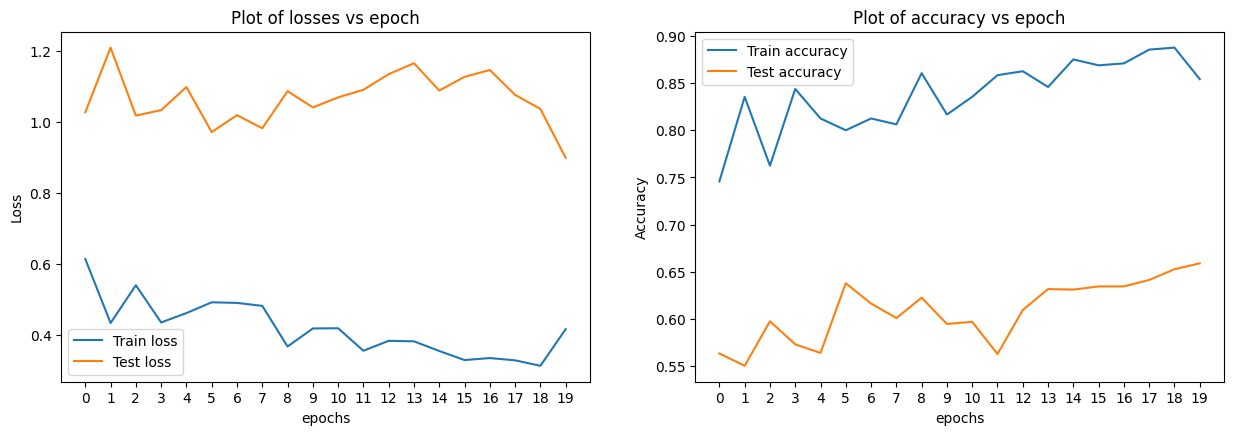

In [46]:
import matplotlib.ticker as mticker

plt.figure(figsize = (15,10))

epochs = range(EPOCHS)

#plot losses
plt.subplot(2,2,1)
plt.plot(epochs, model_df["train_loss"], label = "Train loss")
plt.plot(epochs, model_df["test_loss"], label = "Test loss")
plt.title("Plot of losses vs epoch")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))

plt.subplot(2,2,2)
plt.plot(epochs, model_df["train_acc"], label = "Train accuracy")
plt.plot(epochs, model_df["test_acc"], label = "Test accuracy")
plt.title("Plot of accuracy vs epoch")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))

plt.show()

Much better! In fact it looks like we're overfitting this time. We can include more data augmentation and increase the number of epochs. We might also want to reduce the number of hidden units

In [73]:
def infer(model:torch.nn.Module,
          img_path: str,
          class_names: dict,
          plot: bool = True,
          device: str = device):
    
    Results = dict()

    # Read and process image
    img = torchvision.io.read_image(str(img_path)).type(torch.float32)
    img = img/255.
    img = img.unsqueeze(0) #Add batch dimension
    transform = transforms.Resize(size = (224,224))
    img = transform(img)

    # Run inference
    model.to(device)
    model.eval()
    with torch.inference_mode():
        probs = torch.softmax(model(img.to(device)), dim = 1).cpu()
        preds = torch.argmax(probs, dim = 1).item()
        Results["Probability_score"] = probs.max()
        Results["Preds"] = preds
    
    if plot:
        plt.figure(figsize = (10,10))
        cls = class_names[preds]
        plt.title(f"Predicted label: {cls} | Probability: {probs.max():.3f}")
        plt.imshow(img.cpu().squeeze(0).permute(1,2,0))
        plt.axis(False)
        plt.show()
    
    return Results

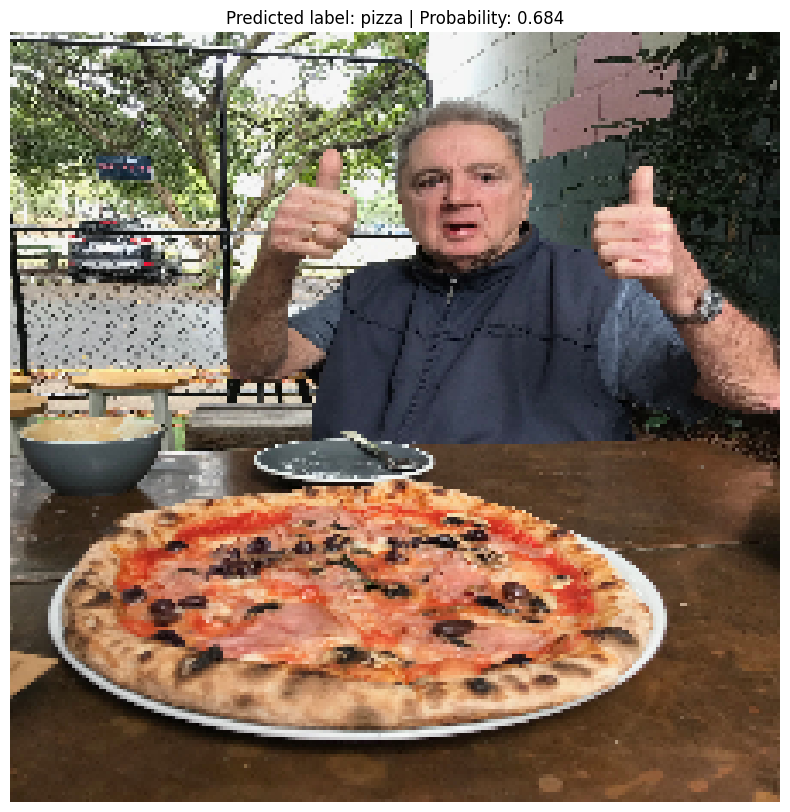

In [74]:
res = infer(model = model,
            img_path = custom_image_path,
            plot = True,
            class_names = class_names)

The algorithm is much more confident about the prediction than before